# Practical session: Representation learning - Variational autoencoders

For those of you who are opening this in Google Colab: To speed all the computations in this notebook up, you can access the GPUs from Google. In the upper right corner of Google Colab there is an arrow pointing downwards (this might be next to the RAM and Disk information if you are already connected; if not, click on the arrow and select "Connect to a hosted runtime"). If you click there, a subtab will open that says on the bottom *Change runtime type*. Click on this and select "GPU" under hardware accelerator and save your changes. 

Doing this will delete your variables (if there are any in the current session), so you will need to rerun all cells.

In [ ]:
%pip install tensorflow-probability

# to generate gifs
%pip install imageio
%pip install git+https://github.com/tensorflow/docs

from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
tf.random.set_seed(42)

In [ ]:
from tensorflow.python.client import device_lib

def select_device(prefer_gpu=True):
    local_device_protos = device_lib.list_local_devices()
    gpus = [x.name for x in local_device_protos if x.device_type == 'GPU']
    if (len(gpus) > 0) and prefer_gpu:
        return gpus[0]
    else:
        return [x.name for x in local_device_protos if x.device_type == 'CPU'][0]

In [ ]:
# This code sets the device to use to GPU if you have one available
device = select_device(prefer_gpu=True)
device

'/device:GPU:0'

<div class="alert alert-block alert-info">
    <h2>Table of Contents </h2><a class="anchor" id="top"></a>
    <br><a href="#section_1">Theory recap</a>
    <br><a href="#section_2">Practical session</a>
    <br><a href="#section_3">Preprocessing the data</a>
    <br><a href="#section_4">Defining the variational autoencoder architecture</a>
    <br><a href="#section_5">Training the model and generating new images</a>
</div>


<h2 style="display: inline"> Theory recap </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1"></a> 

As seen in the theory lecture on Representation learning, the end goal of training a variational auto-encoder is finding a model that approximates the data generating distribution $p_{data}$:

$$\theta*=\textrm{arg}\textrm{min}_{\theta\in\mathcal{M}}d(p_{data},p_\theta)$$

with $d$ the Kullback-Leibler divergence.

It can be shown that this minimization is equivalent to maximizing the log-likelihood $log{p_\theta}$ over a discrete dataset sampled from $p_{data}$. However, computing $log{p_\theta}$ is intractable due to the marginalization over $Z$, the latent random variable.

Therefore, we approximate this problem by maximizing a (tractable) lower-bound on $log{p_\theta}$, namely, the Evidence Lower BOund (ELBO):

$$\log p_\theta(x) \geq \mathbb{E}_{z\sim q_\lambda(z|x)}[\log{\frac{p_\theta(x|z)}{q_\lambda(z|x)}}]$$

In order to be able to sample meaningful latent representations, we impose a unit Gaussian prior on $Z$. This is often referred to as the reparameterization trick. Without the reparameterization trick, backpropagation would be stuck at the random bottleneck node. We cannot backpropagate through a random variable.

Therefore, we introduce a normally distributed random variable $\epsilon$ and we let the encoder output the parameters of a multivariate normal distribution as a vector. A latent representation for an input $x$ can then be constructed as follows:
1. Sample from $\epsilon\sim\mathcal{N}(O, \mathbb{1})$
2. $z = \mu + \sigma \odot \epsilon$

This $z$ can then be passed on to the decoder. The backpropagation can now flow through the parameter vector, that is output by the encoder.

This tricks allows us to construct the VAE loss function:

$$\mathcal{L}(x; \theta, \lambda) = \mathbb{E}_{z\sim q_\lambda(z|x)}[\log{p_\theta(x|z)}] - d_{KL}(q_\lambda(z|x), p_\theta(z))$$

By weighting the $d_{KL}$-term, we obtain the $\beta$-VAE loss function:

$$\mathcal{L}(x; \theta, \lambda, \beta) = \mathbb{E}_{z\sim q_\lambda(z|x)}[\log{p_\theta(x|z)}] - \beta*d_{KL}(q_\lambda(z|x), p_\theta(z))$$

Here, we approximate $\mathcal{L}(x; \theta, \lambda, \beta)$ using a single-sample Monte Carlo Estimate:

$$\log{p_\theta(x|z)} + \beta*(\log{p_\theta(z)} - \log{q_\lambda(z|x)})$$


<h2 style="display: inline"> Practical session</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2"></a> 

Today we will construct a variational autoencoder on the MNIST dataset, with the goal to generate new digit pictures. Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel.

Since we are dealing with a computer vision task, we will use a **convolutional** variational autoencoder (CVAE). The CVAE has the same bottleneck structure as a standard variational autoencoder, but replaces the dense layers with convolutional and tranposed convolutional layers. The former type used in the encoder for down-sampling, and the latter in the decoder for upsampling. As with any autoencoder, the goal of the CVAE is to learn the *identity function*: learn to reconstruct the input image after "squeezing" it through a low-dimensional latent representation, also called the *bottleneck*.

Additionally, we will use a **variational** autoencoder for this task. This means we will use variational inference to find the optimal $\theta$ and $\lambda$ to parameterize, respectively, the decoder $p_\theta(x|z)$ and the encoder $q_\lambda(z|x)$, with $z$ the latent representation.

In order for us to be able to use $p_\theta(x|z)$, we need to first be able to choose a meaningful $z$. Therefore, we will impose a Gaussian prior over $q_\lambda(z|x)$. We'll see how this is done when we define the loss.

<h2 style="display: inline"> Preprocessing the data</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3"></a> 

In [ ]:
# Load in the data
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel value range to [0.1] and threshold all pixels at 0.5
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

# Perform training and test splits
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Set parameters
train_size = 60000
batch_size = 256
test_size = 10000

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# Shuffle the dataset and divide in batches
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

<h2 style="display: inline"> Defining the variational autoencoder architecture</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4"></a> 

**TASK 1**

Implement the reparameterization trick in the `reparameterize` function below.

**NOTE**:
We use the log-normal distribution for numerical stability during training. This means:

$$ \sigma = \sqrt{e^\textrm{logvar}} $$

In [ ]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        subsampled_size = 7
        input_shape = (28, 28, 1)

        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=input_shape),
              tf.keras.layers.Conv2D( # This layer will downsample the image to half its width and height
                  filters=32, kernel_size=3, strides=(2,2), activation='relu'),
              tf.keras.layers.Conv2D( # This layer will downsample the image again to half its current width and height
                  filters=64, kernel_size=3, strides=(2,2), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim)])

        self.generative_net = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=subsampled_size*subsampled_size*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(subsampled_size, subsampled_size, 32)),
              tf.keras.layers.Conv2DTranspose( # This layer will upsample the image to twice its current width and height
                  filters=64,
                  kernel_size=3,
                  strides=2,
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose( # This layer will upsample the image again to twice its current width and height
                  filters=32,
                  kernel_size=3,
                  strides=2,
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=input_shape[-1], kernel_size=3, strides=1, padding="SAME")] )

    @tf.function
    def sample(self, z=None): # Not really needed here, a way to decode latent variables (sample/generate a new instance)
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        # sample random noise
        eps = tf.random.normal(shape = mean.shape)
        #perform reparameterization
        new_values = mean + eps*(tf.exp(logvar)**(0.5))
        return new_values

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

**TASK 2**

Complete the missing parts in the function below to compute the loss.

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


$$\log{p(x|z)} + \beta*(\log{p(z)} - \log{q(z|x)})$$

In [ ]:
def compute_loss(model, x_true, beta=1):
    mu, logvar = model.encode(x_true) # parameters for the multivariate normal posterior
    z = model.reparameterize(mu, logvar) # a sample from the posterior
    x_recons_logits = model.decode(z) # the reconstruction of the sample

    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true,
                        logits=x_recons_logits)

    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])

    logpz = log_normal_pdf(z, 0., 0.) # density of the prior evaluated at z_sample
    logqz_x = log_normal_pdf(z, mu, logvar)  # density of the latent posterior evaluated at z_sample
    kl_divergence = logqz_x - logpz

    elbo = tf.math.reduce_mean(-beta * kl_divergence - neg_log_likelihood)

    return dict(
        loss=-elbo,
        reconstruction=-neg_log_likelihood,
        kl=-kl_divergence
    )

In [ ]:
@tf.function
def compute_apply_gradients(model, x, optimizer, beta=1):
    with tf.GradientTape() as tape: # records operations for automatic differentiation
        loss = compute_loss(model, x, beta=beta)["loss"]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<h2 style="display: inline"> Training the model and generating new images</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_5"></a> 

**TASK 3**

Now it is time to train the $\beta$-VAE.

First, create a CVAE model with 2 latent dimensions. Then, create an Adam optimizer with a learning rate of 0.001. Finally, implement the iterative training procedure.

Training pseudocode:
```
for every epoch
    for every batch in train dataset
        compute loss and apply gradients
        
    for every batch in test dataset
        compute loss
    
    print test set loss
```
Make sure to use the `compute_apply_gradients` and `compute_loss` functions. Set $\beta$ to 3.

Complete the code to generate new images and compare the results of the first epoch to the last.



In [ ]:
epochs = 10
latent_dim = 2

# define model
model = CVAE(latent_dim)

# define the optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Pick a sample of the test set for generating output images
num_examples_to_generate = 16
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

def generate_images(model, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

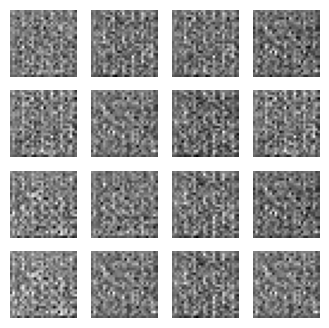

In [ ]:
generate_images(model,test_sample ) # untrained model

1
Epoch: 1, Test set ELBO: 249.73646545410156, time elapse for current epoch: 17.04794716835022
2
Epoch: 2, Test set ELBO: 213.1150360107422, time elapse for current epoch: 2.1541011333465576
3
Epoch: 3, Test set ELBO: 187.36309814453125, time elapse for current epoch: 2.1571874618530273
4
Epoch: 4, Test set ELBO: 203.43142700195312, time elapse for current epoch: 2.166259527206421
5
Epoch: 5, Test set ELBO: 166.90406799316406, time elapse for current epoch: 2.2188732624053955
6
Epoch: 6, Test set ELBO: 191.14041137695312, time elapse for current epoch: 2.1811227798461914
7
Epoch: 7, Test set ELBO: 184.5866241455078, time elapse for current epoch: 2.1920325756073
8
Epoch: 8, Test set ELBO: 147.10702514648438, time elapse for current epoch: 2.198728084564209
9
Epoch: 9, Test set ELBO: 179.895263671875, time elapse for current epoch: 2.230398416519165
10
Epoch: 10, Test set ELBO: 189.55838012695312, time elapse for current epoch: 2.210775375366211


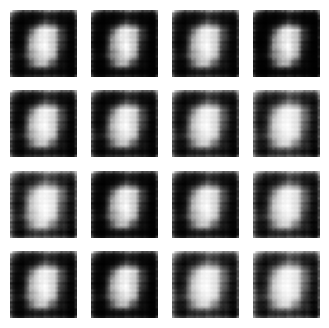

In [ ]:
# Note: this can take quite a while, it takes appr. 94s for one epoch without gpu's.
for epoch in range(1, epochs + 1):
  print(epoch)
  if epoch == 2:
    generate_images(model,test_sample)
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, beta=3)
  end_time = time.time()

  for test_x in test_dataset:
    loss = compute_loss(model, test_x, beta=3)
  elbo = loss['loss']
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))


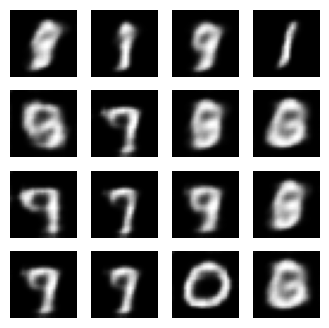

In [ ]:
generate_images(model,test_sample )